Epoch 1/20


I0000 00:00:1730686484.941791      97 service.cc:145] XLA service 0x7b8db8004c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730686484.941849      97 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730686484.941853      97 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.2275  

I0000 00:00:1730686495.915997      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 405ms/step - loss: 0.0732
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - loss: 0.0026
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 0.0026
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.0029
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0027
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.0030
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 0.0022
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.0022
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0024
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.0019
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 0.0025
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 0.0026
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 0.0028
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 0.0026
Epoch 15/20
100/100 ━━━━━━

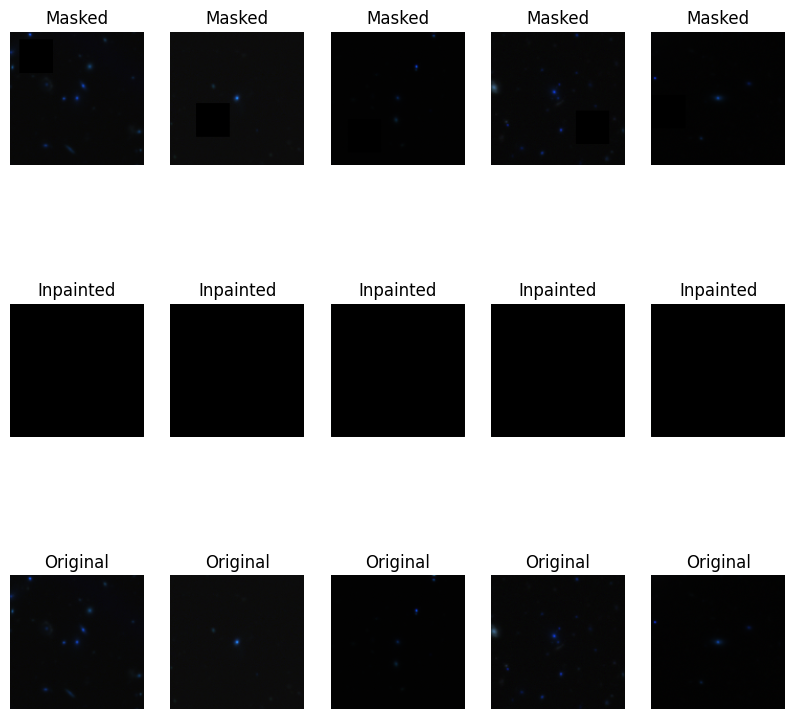

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt

def resize_and_mask_image(image, target_size=(128, 128), mask_size=32):
    image_resized = cv2.resize(image, target_size)
    
    masked_image = image_resized.copy()
    h, w, _ = image_resized.shape
    top_left_x = np.random.randint(0, h - mask_size)
    top_left_y = np.random.randint(0, w - mask_size)
    masked_image[top_left_x:top_left_x + mask_size, top_left_y:top_left_y + mask_size] = 0
    
    return masked_image, image_resized

def inpainting_generator(files, batch_size, target_size=(128, 128)):
    while True:
        batch_images = []
        batch_masks = []
        
        batch_files = np.random.choice(files, batch_size)
        for file_path in batch_files:
            image = np.load(file_path)
            if image.shape[0] == 3: 
                image = np.dstack(image[:3])  
            
            image = (image - np.min(image)) / (np.max(image) - np.min(image))
            masked_image, original_image = resize_and_mask_image(image, target_size=target_size)
            
            batch_images.append(masked_image)
            batch_masks.append(original_image)
        
        yield np.array(batch_images), np.array(batch_masks)

def build_inpainting_model(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output layer

    model = models.Model(inputs, x)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
batch_size = 64
input_shape = (128, 128, 3)

data_path = '/kaggle/input/real-dataset-cleaned/dataset/'
file_paths = []
for class_name in ['lenses', 'nonlenses']:
    class_dir = os.path.join(data_path, class_name)
    file_paths += [os.path.join(class_dir, file) for file in os.listdir(class_dir)]

inpainting_model = build_inpainting_model(input_shape=input_shape)
train_generator = inpainting_generator(file_paths, batch_size=batch_size)

inpainting_model.fit(train_generator, steps_per_epoch=100, epochs=20)

masked_images, original_images = next(train_generator)
predicted_images = inpainting_model.predict(masked_images)

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(masked_images[i])
    plt.title("Masked")
    plt.axis('off')

    # Display inpainted prediction
    plt.subplot(3, 5, i+6)
    plt.imshow(predicted_images[i])
    plt.title("Inpainted")
    plt.axis('off')

    # Display original image
    plt.subplot(3, 5, i+11)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis('off')

plt.show()

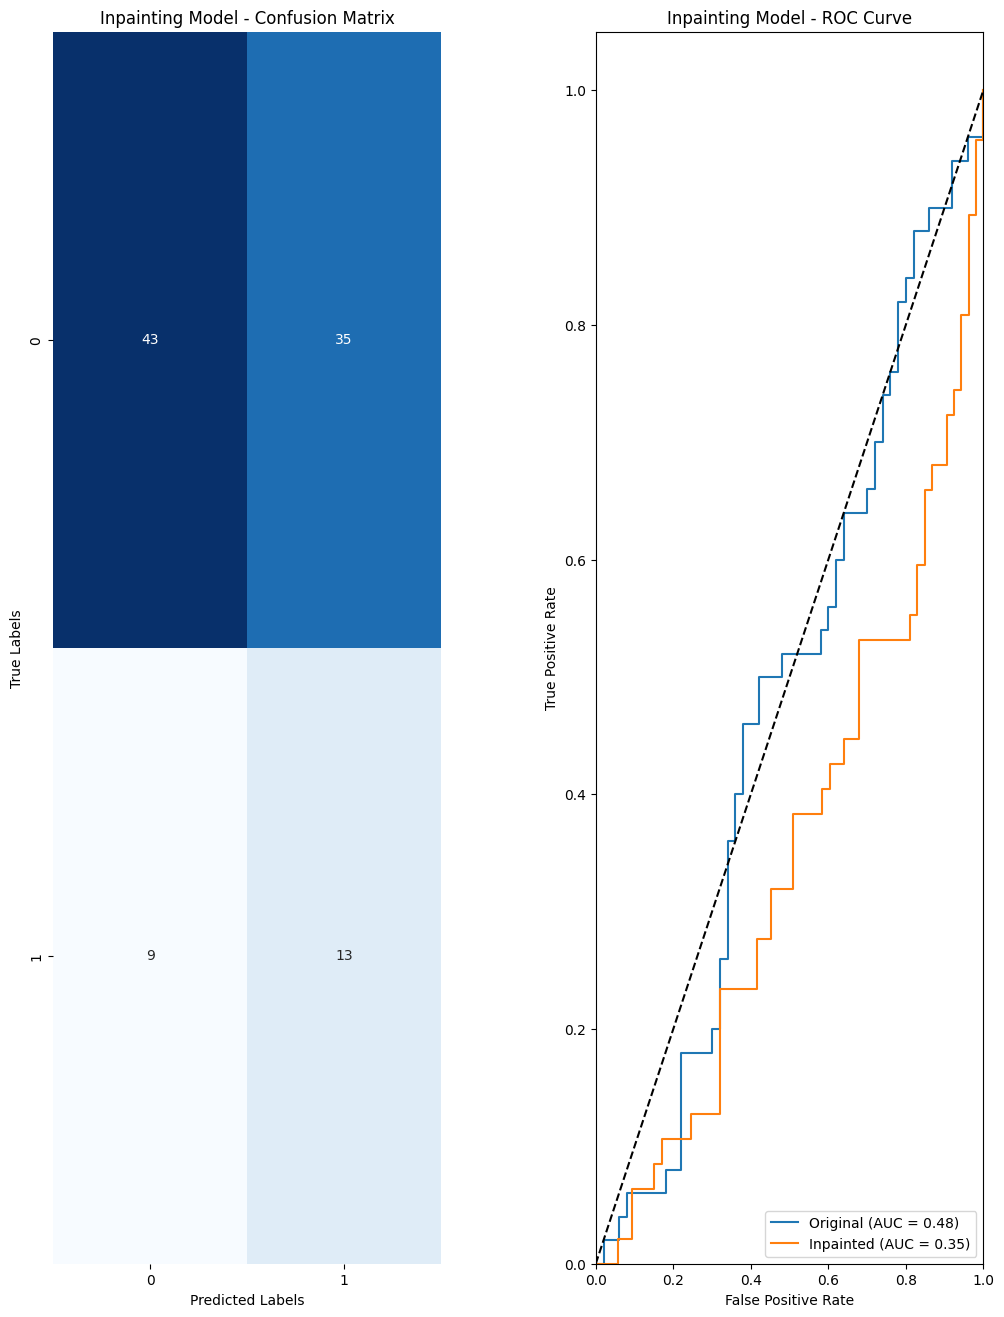

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error
import seaborn as sns
import tensorflow as tf

class_indices = {'Original': 0, 'Inpainted': 1}

y_true_original = np.random.randint(2, size=(100, 2))  
y_pred_original = np.random.rand(100, 2) 

datasets = {
    "Inpainting Model": (y_true_original, y_pred_original)
}

plt.figure(figsize=(12, 16))

for idx, (title, (y_true, y_pred)) in enumerate(datasets.items()):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    
    plt.subplot(len(datasets), 2, 2 * idx + 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    fpr, tpr, roc_auc = {}, {}, {}
    for key, value in class_indices.items():
        fpr[value], tpr[value], _ = roc_curve(y_true[:, value], y_pred[:, value])
        roc_auc[value] = auc(fpr[value], tpr[value])
    plt.subplot(len(datasets), 2, 2 * idx + 2)
    for class_name, i in class_indices.items():
        plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'{title} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()


In [11]:
masked_images, original_images = next(train_generator)
predicted_images = inpainting_model.predict(masked_images)
mse_scores = [mean_squared_error(original.flatten(), predicted.flatten())
              for original, predicted in zip(original_images, predicted_images)]
ssim_scores = [tf.image.ssim(tf.convert_to_tensor(original), tf.convert_to_tensor(predicted), max_val=1.0).numpy()
               for original, predicted in zip(original_images, predicted_images)]
print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average SSIM: {np.mean(ssim_scores):.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Average MSE: 0.0028
Average SSIM: 0.4188
